## Investigating incentive compatible AMMs in binary prediction markets
#### Arya Maheshwari, Janum Shah, Abiram Gangavaram
This notebook presents the essential pieces of code for our ECE/COS473 final project. This is primarily related to our simulations of a prediction market with the LMSR and LS-LMSR scoring rules, as described in Section 3 of our paper.

In [1]:
import numpy as np
import random 
from matplotlib import pyplot as plt
import copy

### BettingMarket class
This class defines the main functions for a prediction market, setting the quantity and cost/price functions, the ability to input bets into the market, etc 

In [2]:
class BettingMarket: 
    '''
    Notes on BettingMarket assumptions and preconditions:
    - Only supports markets/rules that "move forward in obligation space" (as LS-LMSR requires)
       i.e. assumes traders interacting with market can only do "buy" orders (but note effect of buying item 2 ~= effect of selling item 1)
    '''
    def __init__(self, n, init_quant, msr_type, alpha, b, true_dist, **kwargs):
        self.n = n
        self.q = init_quant # a list of length n
        self.msr = msr_type # a string representing type market scoring rule
        if self.msr == "Rikkido":
            self.set_rikkido_params(t=kwargs['t'], tk=kwargs['tk'], scale=(kwargs['scale'] if 'scale' in kwargs else None), slope_const=(kwargs['slope_const'] if 'slope_const' in kwargs else None))
        self.alpha = alpha  # the constant 'alpha' for LS-LMSR
        self.b = b          # the constant 'b' for LMSR
        
        self.true_dist = true_dist # a "ground truth" probability distribution from which to draw the result 
        self.outcome = None 

        self.traders = []
        self.init_q = init_quant 
        self.init_cost = self.cost(self.q)
        # self.revenue = -self.init_cost
    
    
    def set_rikkido_params(self, t: int, tk: int, scale=None, slope_const=None):
        '''
        '''
        self.t = t     # numerator window for EMA calculation
        self.tk = tk   # denominator window for EMA calculation
        self.scale = scale
        self.slope_const = slope_const
        self.prev_ema_t = None 
        self.prev_ema_tk = None
        self.bets = [] # list of tuples: [trader_id, total_bet_amt] where adjacent tuples should have different trader_id 
        

    def cost_LMSR(self, b, q):
        return b*np.log(np.sum(np.exp(np.array(q)/b)))

    def get_b(self):
        if self.msr == "LMSR":
            return self.b
        elif self.msr=="LSLMSR":
            return self.alpha*np.sum(self.q)
        else:
            return self.compute_rikkido_alpha()*np.sum(self.q) 
    
    def cost(self, q):
        return self.cost_LMSR(self.get_b(), q)

    def get_price_vector(self, q):
        return [self.get_price(i, q) for i in range(len(q))]

    def get_price_prob(self, q):
        price_vec = self.get_price_vector(q)
        return np.array(price_vec)/np.sum(price_vec)
    
    def get_price(self, i, q):
        if self.msr == "LMSR":
            return np.exp(q[i]/self.b)/np.sum(np.exp(np.array(q)/self.b))
        elif self.msr == "LSLMSR": 
            b = self.alpha*sum(q)
            sum_term = np.sum(np.exp(np.array(q)/b))
            term1 = self.alpha * np.log(sum_term)
            term2_num = (np.sum(q)*np.exp(q[i]/b) - np.sum([x*np.exp(x/b) for x in q]))
            term2_denom = np.sum(q)*sum_term
            return term1 + term2_num/term2_denom
        else: # Rikkido: do analytically (approximation)
            dx = 1e-6
            q_upd = copy.deepcopy(self.q)
            q_upd[i]+=dx
            return (self.cost(q_upd)-self.cost(self.q))/dx

    def submit_bet(self, trader, delta, verbose=False):
        if self.msr == "Rikkido":
            #################################
            ## processing specific to Rikkido
            if len(self.bets)==0 or trader.id != self.bets[-1][0]: 
                if len(self.bets) > 0: # update moving averages (most recent trader has completed trading)
                    self.update_vol_ema(self.t)
                    self.update_vol_ema(self.tk)
                self.bets.append([trader.id, np.sum(delta)])
            else: # last registered trade was made by this trader
                self.bets[-1][1] += np.sum(delta)
            #################################
        new_q = [sum(x) for x in zip(self.q, delta)]
        curr_cost = self.cost(self.q)
        new_cost = self.cost(new_q)
        if(new_cost-curr_cost > trader.money):
            if verbose:
                print("Insufficient trader funds: trader money={m}, transaction cost={c}".format(m=trader.money, c=new_cost-curr_cost))
            return None
        self.q = new_q
        trader.money -= (new_cost-curr_cost)
        trader.payouts = [sum(x) for x in zip(trader.payouts, delta)]
        if verbose:
            print("Trader", trader.id, "updates to", self.q, "for cost of", (new_cost-curr_cost))
        return new_cost - curr_cost
    
    def get_revenue(self, outcome):
        # NOTE: Revenue function: current definition is C(q)-C(q0)-z_i, where z_i is the payout for the outcome i (not total quantity_i)
        #  (as this seems to match the numerical values used in Othman et al.)
        return self.cost(self.q)-self.init_cost-(self.q[outcome]-self.init_q[outcome])
        # return self.cost(self.q)-self.init_cost-self.q[outcome]
    
    def get_expected_revenue(self):
        revs = [self.get_revenue(i) for i in range(len(self.q))]
        return np.dot(self.get_price_prob(self.q), np.array(revs))
    
    def get_market_state(self, silence=False):
        if self.outcome is None: # draw the outcome the first time this is called
            self.outcome = random.choices(list(range(self.n)), weights=self.true_dist)[0]
        
        revenue = self.get_revenue(self.outcome)
        if not silence:
            print("State:", self.q)
            print("Final instantaneous prices:", [self.get_price(0, self.q), self.get_price(1, self.q)])
            print("Outcome realized:", self.outcome)
            print("Revenue:", revenue)
    
    ##################################
    ### RIKKIDO-specific FUNCTIONS ### 
    def update_vol_ema(self, m: int):
        ''' 
        Parameters:
          - m: to compute m-day EMA (should be either self.t or self.tk)
        Notes:
          - Recall self.bets is a list of [trader_id, bet_amt]: so need to use self.bets[-1][1] for volume
          - EMA formula: EMA_i = (V - EMA_{i-1})*c + EMA_{i-1}, where c = 2 / (m + 1)
          - Updates corresponding self.ema_m to EMA_m if len(bets) > m, SMA_len(bets) otherwise
        '''
        assert len(self.bets) > 0    
        if len(self.bets) <= m: # returns how many ever days it can average so far
            if m == self.tk:
                self.prev_ema_tk = np.mean(self.bets)
            if m == self.t:
                self.prev_ema_t = np.mean(self.bets)
        else: 
            if m == self.tk:
                self.prev_ema_tk = (self.bets[-1][1] - self.prev_ema_tk)*(2/(m+1)) + self.prev_ema_tk
            else:
                self.prev_ema_t = (self.bets[-1][1] - self.prev_ema_t)*(2/(m+1)) + self.prev_ema_t
            
    def func_z(self, r, scale = 0.1, n=1, slope_const = 3):
        ''' 
        Notes:
        - scale, slope_const: hyperparameters to fine-tune Rikkido effects
        - if want func_z(r) to be 0 at r = 1, keep n=1
        - formula: scale*(r-n) / sqrt(slop_const + (r-n)^2)
        - for n = 1, slope_const = 3: most negative will be scale*1/2, so generally set scale = alpha 
        '''
        return scale*(r-n)/ (np.sqrt(slope_const + (r-n)**2)) # sigmoid function 
    
    def compute_rikkido_alpha(self):
        '''
        Compute alpha = f + z(r)
        '''
        f = self.alpha # Note: this will always be a "fixed" alpha (based on LS-LMSR) 
        r = self.prev_ema_t/self.prev_ema_tk if self.prev_ema_t is not None else 1        
        slope_const_val = self.slope_const if self.slope_const is not None else 3
        scale_val = self.scale if self.scale is not None else f
        return f + self.func_z(r, scale_val, 1, slope_const_val) # z(r) 
    ##################################


### Trader class
This class represents the Traders that interact with BettingMarket, keeping track of better's individual beliefs and payouts, and importantly defining a function for their behavior ('play')

In [3]:
class Trader:
    def __init__(self, id, n, init_money):
        self.n = n
        self.id = id
        self.money = init_money
        self.payouts = [0]*n
    
    def set_belief(self, prob_vector):
        self.belief = prob_vector
    
    def bet(self, mkt: BettingMarket, i, amt, verbose=False):
        delta = [(1 if i==j else 0)*amt for j in range(self.n)]
        return mkt.submit_bet(self, delta, verbose)

    def play(self, mkt: BettingMarket, DELTA_FRAC=0.002, MAX_ITER=2/0.002, verbose=False):
        '''
         Makes bet for this Trader's turn by buying each asset while its price is less than probability distribution belief
           if Trader can afford the bet
         DELTA_FRAC: fraction of market to buy in each evaluation (in each delta/step) of price vs belief -- sets discretizing error
         MAX_ITER: sets maximum number of times for evaluating the price/probability and betting DELTA_FRAC of market
        '''
        flag=True
        init_cost = mkt.cost(mkt.q)
        init_payouts = self.payouts

        bet_cost = True
        if(mkt.get_price(0, mkt.q) < self.belief[0]):
            while(MAX_ITER >= 0 and mkt.get_price(0, mkt.q) < self.belief[0] and bet_cost is not None):
                bet_cost = self.bet(mkt, 0, DELTA_FRAC*mkt.q[0])
                MAX_ITER-=1
        elif(mkt.get_price(1, mkt.q) < self.belief[1]):   
            while(MAX_ITER >= 0 and mkt.get_price(1, mkt.q) < self.belief[1] and bet_cost is not None):
                bet_cost = self.bet(mkt, 1, DELTA_FRAC*mkt.q[1])
                MAX_ITER-=1

        if(MAX_ITER < 0):
            print("LOG: play() function hit MAX_ITER")
        
        final_cost = mkt.cost(mkt.q)
        if(verbose):
            print("Cost of transaction:", final_cost-init_cost)
            print("Expected final return after transaction:", sum(self.belief[i]*self.payouts[i] for i in range(self.n)))
            print("Current price vs beliefs:", [mkt.get_price(0, mkt.q), mkt.get_price(1, mkt.q)], self.belief)

        bet = [x[0]-x[1] for x in zip(self.payouts, init_payouts)]
        return bet, final_cost-init_cost

### Simulation class
The Simulation class encapsulates a number of helper functions for simulations, as well as the infrastructure for the main simulation

In [4]:
class Simulation:

    def __init__(self):
        self.betters = []


    def draw_unif_ground_truth(self, low, high):
        p0 = low+(high-low)*random.random()
        return [p0, 1-p0]

    def create_market_comp(self, init_quant, msr1, msr2, msr1_const, msr2_const, ground_truth):
        b1 = BettingMarket(2, init_quant, msr1, (None if msr1 == "LMSR" else msr1_const), (None if msr1 == "LS-LMSR" else msr1_const), ground_truth)
        b2 = BettingMarket(2, init_quant, msr2, (None if msr2 == "LMSR" else msr2_const), (None if msr2 == "LS-LMSR" else msr2_const), ground_truth)
        return [b1, b2]

    def compute_b(self, alpha, init_quant):
        lslmsr =  BettingMarket(2, init_quant, "LSLMSR", alpha, None, [-1, -1])
        worst_case_loss = lslmsr.init_cost # worst-case LS-LMSR loss is just C(q0)
        
        # worst-case LMSR loss is -b ln (exp(q0_i /b) / sum(exp(q0_j / b))), where q0_i is the max value in init_quant
        # Here we just implement the uniform distribution case, for which the formula reduces to b ln(n) 
        uniform_flag = True
        for x in init_quant:
            if not x == init_quant[0]:
                uniform_flag = False
                break
        assert(uniform_flag)
        b = worst_case_loss / np.log(2)
        return b, worst_case_loss
    
    def simple_noise_sim(self, ntraders, trader_money, markets, priv_info_noise=0.2, look_back = 50, k=0.5, k_min=None, k_max=None, silence=False, verbose=False):
        '''
        Idea: at each time instant (for each trader), 
          (1) draw some (noisy) private info
          (2) use average of last look_back market prices 
          (3) trader belief is a weighted average (weighted by k) of market average and private info 
        Parameters:
         - priv_info_noise: private info will be uniform in [ground_truth-priv_info_noise, ground_truth+priv_info_noise]
             (Note: for intended simulation, this should be pretty noisy!)
         - look_back: number of previous market price beliefs to consider 
         - k: weight for weighted average belief (OR: k_min --> k_max)
        '''
        b1, b2 = markets[0], markets[1]
        assert(b1.true_dist == b2.true_dist)
       
        if not silence:
            print('\n\nGROUND TRUTH:', b1.true_dist)
            print('priv_info_noise:', priv_info_noise, '; look_back:', look_back, '; k:', k)
            print('INITIAL PRICE: LMSR', [b1.get_price_vector(b1.q)])
            print('INITIAL PRICE: LS-LMSR', [b2.get_price_vector(b2.q)], '\n')
        
        traders_b1 = []
        bets_b1 = []
        costs_b1 = []
        traders_b2 = []
        bets_b2 = []
        costs_b2 = []
        prev_b1market_p0 = []
        prev_b2market_p0 = []

        for i in range(ntraders):
            traderv1 = Trader(i, 2, trader_money)
            traders_b1.append(traderv1)
            traderv2 = Trader(i, 2, trader_money)
            traders_b2.append(traderv2)

            prev_b1market_p0.append(b1.get_price_prob(b1.q)[0])
            prev_b2market_p0.append(b2.get_price_prob(b2.q)[0])

            # MAIN: Set this trader i's belief: lambda*(priv_info) + (1-lambda)*(market_avg_till_now, up to look_back)
            # 1. some private info distributed noisily around ground truth 
            priv_info = min(random.random()*(2*priv_info_noise)+max(b1.true_dist[0]-priv_info_noise, 0.001), 0.999)
            trad_b1_p0, trad_b2_p0 = priv_info, priv_info
            # 2. compute average of look_back previous market values
            b1avg, b2avg  = np.mean(prev_b1market_p0[-1*min(look_back, i+1):]), np.mean(prev_b2market_p0[-1*min(look_back, i+1):])
            # 3. weight previous market prob values with private info based on k: k*(MY INFO)+(1-k)*(MARKET AVG)
            #      with possibility for using a k linearly varying from **k_max to k_min** (note direction!) across ntraders
            #       e.g. 1st trader uses k=k_max=0.8 (rely on private info), final trader uses k=k_min=0.2 (rely on market avg)
            k = ((k_max+(k_min-k_max)*(i+1)/ntraders) if k_min is not None else k)
            trad_b1_p0 = k*trad_b1_p0 + (1-k)*b1avg
            trad_b2_p0 = k*trad_b2_p0 + (1-k)*b2avg 

            traderv1.set_belief([trad_b1_p0, 1-trad_b1_p0])
            traderv2.set_belief([trad_b2_p0, 1-trad_b2_p0])
            if not silence:
                print("LMSR market trader", i, ":")
            bet1, cost1 = traderv1.play(b1, verbose=verbose)
            bets_b1.append(bet1)
            costs_b1.append(cost1)
            if not silence:
                print("Final: bet:", bet1, "cost:", cost1)
                print('------')

                print("LS-LMSR market trader", i, ":")
            bet2, cost2 = traderv2.play(b2, verbose=verbose)
            bets_b2.append(bet2)
            costs_b2.append(cost2)
            if not silence:
                print("Final: bet:", bet2, "cost:", cost2)
                print()
        if not silence:
            print('==========')
            print('LMSR market: ')
        b1.get_market_state(silence=silence)
        if not silence:
            print()
            print('LS-LMSR market')
        b2.get_market_state(silence=silence)

        return (b1.get_price_prob(b1.q), b2.get_price_prob(b2.q), b1.get_expected_revenue(), b2.get_expected_revenue(), b1.get_revenue(b1.outcome), b2.get_revenue(b2.outcome), b1.outcome, b2.outcome)
#         return (b1.get_price_prob(b1.q), b2.get_price_prob(b2.q), b1.get_expected_revenue(), b2.get_expected_revenue())
    
    
    # This runs a toy-model simulation where traders all exactly know the ground truth (mainly for testing purposes)
    def perfect_trader_sim(self, ntraders, trader_money, markets, silence=False, verbose=False):
        b1, b2 = markets[0], markets[1]
        assert(b1.true_dist == b2.true_dist)
       
        if not silence:
            print('\n\nGROUND TRUTH:', b1.true_dist)
            print('INITIAL PRICE: LMSR', [b1.get_price_vector(b1.q)])
            print('INITIAL PRICE: LS-LMSR', [b2.get_price_vector(b2.q)], '\n')

        traders_b1 = []
        bets_b1 = []
        costs_b1 = []
        traders_b2 = []
        bets_b2 = []
        costs_b2 = []

        for i in range(ntraders):
            traderv1 = Trader(i, 2, trader_money)
            traderv1.set_belief(b1.true_dist)
            traders_b1.append(traderv1)
            traderv2 = Trader(i, 2, trader_money)
            traderv2.set_belief(b1.true_dist)
            traders_b2.append(traderv2)
            
            if not silence:
                print("LMSR market trader", i, ":")
            bet1, cost1 = traderv1.play(b1, verbose=verbose)
            bets_b1.append(bet1)
            costs_b1.append(cost1)
            if not silence:
                print("Final: bet:", bet1, "cost:", cost1)
                print('------')

                print("LS-LMSR market trader", i, ":")
            bet2, cost2 = traderv2.play(b2, verbose=verbose)
            bets_b2.append(bet2)
            costs_b2.append(cost2)
            if not silence:
                print("Final: bet:", bet2, "cost:", cost2)
                print()
        if not silence:
            print('==========')
            print('LMSR market: ')
        b1.get_market_state(silence=silence)
        if not silence:
            print('\n LS-LMSR market')
        b2.get_market_state(silence=silence)
        return (b1.get_price_vector(b1.q), b2.get_price_vector(b2.q), b1.get_revenue(b1.outcome), b2.get_revenue(b2.outcome))
    


### Noisy information simulation: various experiments (with different parameters) 

#### 1. Run a simple noisy information simulation (for testing / logging purposes)

In [5]:
s = Simulation()
ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
init_quant = [100, 100]
alpha = 0.03
markets = s.create_market_comp(init_quant, 'LMSR', 'LSLMSR', s.compute_b(alpha, init_quant)[0], alpha, ground_truth)
# b1_prob, b2_prob, b1_exprev, b2_exprev = s.noisyinfo_sim(10, 10000000, markets, silence=False, verbose=False)
b1_prob, b2_prob, b1_exprev, b2_exprev, _, _, _, _ = s.simple_noise_sim(10, 10000000, markets, verbose=True)
print()
print("LMSR price probabilities:", b1_prob)
print("LS-LMSR price probabilities:", b2_prob)
print("LMSR expected revenue:", b1_exprev)
print("LS-LMSR expected revenue:", b2_exprev)



GROUND TRUTH: [0.6059060290696489, 0.39409397093035115]
priv_info_noise: 0.2 ; look_back: 50 ; k: 0.5
INITIAL PRICE: LMSR [[0.5, 0.5]]
INITIAL PRICE: LS-LMSR [[0.5207944154167983, 0.5207944154167983]] 

LMSR market trader 0 :
Cost of transaction: 16.27655101228649
Expected final return after transaction: 17.063638339306117
Current price vs beliefs: [0.5513278833383096, 0.4486721166616905] [0.5511310312667891, 0.4488689687332109]
Final: bet: [30.961127882937202, 0.0] cost: 16.27655101228649
------
LS-LMSR market trader 0 :
Cost of transaction: 0.4312372015671144
Expected final return after transaction: 0.44222930398958127
Current price vs beliefs: [0.5539787500132828, 0.4874773096096948] [0.5511310312667891, 0.4488689687332109]
Final: bet: [0.8024032016, 0.0] cost: 0.4312372015671144

LMSR market trader 1 :
Cost of transaction: 24.83531570342103
Expected final return after transaction: 26.952142954247492
Current price vs beliefs: [0.46734038748251133, 0.5326596125174887] [0.4675603915

#### 2. Run noisy information simulation, independent variable = $\alpha$
(This is the code for generating Figures 3 and 4 in the paper)

In [6]:
vigs = np.arange(0.02, 0.4, 0.02)
alphas = vigs/(2*np.log(2))

N_TRADERS = 20
init_quant = [100, 100]
N_TRIALS = 40
LOOK_BACK = int(N_TRADERS/4)
K = 0.3
K_MIN = 0.2
K_MAX = 0.6
PRIV_NOISE = 0.2
trader_money_cap = 10000000

acc_LS = []
acc_quartiles_LS = []
acc_LMSR = []
acc_quartiles_LMSR = []
exprev_LMSR = []
exprev_quartiles_LMSR = []
exprev_LS = []
exprev_quartiles_LS = []

wcls= [] # worst-case losses 

for alpha in alphas:
    s = Simulation()
    acc_LS_temp = []
    acc_LMSR_temp = []
    exprev_LMSR_temp = []
    exprev_LS_temp = []

    b, worst_case_loss = s.compute_b(alpha, init_quant)
    # print(b, worst_case_loss)
    wcls.append(-worst_case_loss)

    for i in range(N_TRIALS):
        ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
        markets = s.create_market_comp(init_quant, 'LMSR', 'LSLMSR', b, alpha, ground_truth)
        b1, b2 = markets[0], markets[1]
        b1_prob, b2_prob, b1_exprev, b2_exprev, _, _, _, _= s.simple_noise_sim(N_TRADERS, trader_money_cap, markets, priv_info_noise=PRIV_NOISE,look_back=LOOK_BACK, k_min=K_MIN, k_max=K_MAX, silence=True, verbose=False)
        acc_LS_temp.append(1-abs(b2_prob[0]-ground_truth[0]))
        acc_LMSR_temp.append(1-abs(b1_prob[0]-ground_truth[0]))
        exprev_LS_temp.append(b2_exprev)
        exprev_LMSR_temp.append(b1_exprev)
    
    acc_LMSR.append(np.median(acc_LMSR_temp))
    acc_LS.append(np.median(acc_LS_temp))
    exprev_LMSR.append(np.median(exprev_LMSR_temp))
    exprev_LS.append(np.median(exprev_LS_temp))
    acc_quartiles_LMSR.append([np.median(acc_LMSR_temp)-np.quantile(acc_LMSR_temp, 0.25), np.quantile(acc_LMSR_temp, 0.75)-np.median(acc_LMSR_temp)])
    acc_quartiles_LS.append([np.median(acc_LS_temp)-np.quantile(acc_LS_temp, 0.25), np.quantile(acc_LS_temp, 0.75)-np.median(acc_LS_temp)])
    exprev_quartiles_LMSR.append([np.median(exprev_LMSR_temp)-np.quantile(exprev_LMSR_temp, 0.25), np.quantile(exprev_LMSR_temp, 0.75)-np.median(exprev_LMSR_temp)])
    exprev_quartiles_LS.append([np.median(exprev_LS_temp)-np.quantile(exprev_LS_temp, 0.25), np.quantile(exprev_LS_temp, 0.75)-np.median(exprev_LS_temp)])


exprev_quartiles_LMSR = [[exprev_quartiles_LMSR[i][0] for i in range(len(alphas))], [exprev_quartiles_LMSR[i][1] for i in range(len(alphas))]] 
exprev_quartiles_LS = [[exprev_quartiles_LS[i][0] for i in range(len(alphas))], [exprev_quartiles_LS[i][1] for i in range(len(alphas))]] 
acc_quartiles_LMSR = [[acc_quartiles_LMSR[i][0] for i in range(len(alphas))], [acc_quartiles_LMSR[i][1] for i in range(len(alphas))]] 
acc_quartiles_LS = [[acc_quartiles_LS[i][0] for i in range(len(alphas))], [acc_quartiles_LS[i][1] for i in range(len(alphas))]] 

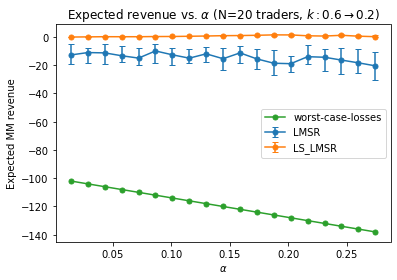

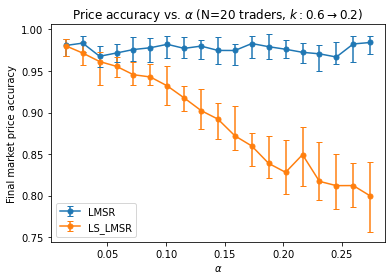

In [7]:
## Plot results

## A. Expected revenue vs alpha
## note: this plots medians and 1st/3rd quartile for error bars
plt.errorbar(alphas, exprev_LMSR, yerr=exprev_quartiles_LMSR, marker='o',markersize=5, capsize=3, label='LMSR')
plt.errorbar(alphas, exprev_LS, yerr=exprev_quartiles_LS, marker='o',markersize=5, capsize=3, label='LS_LMSR')
plt.plot(alphas, wcls, marker='o',markersize=5, label='worst-case-losses')
plt.ylabel('Expected MM revenue')
plt.title(r'Expected revenue vs. $\alpha$ (N=20 traders, $k: 0.6 \rightarrow 0.2$)')
plt.xlabel(r'$\alpha$')
plt.legend()
# plt.savefig('figs/simple_noise_exprev_alpha.png')
plt.show()

## B. Accuracy vs alpha  vs ALPHA 
## note: this plots medians and 1st/3rd quartile for error bars
plt.errorbar(alphas, acc_LMSR, yerr=acc_quartiles_LMSR, marker='o',markersize=5, capsize=3, label='LMSR')
plt.errorbar(alphas, acc_LS, yerr=acc_quartiles_LS, marker='o',markersize=5, capsize=3, label='LS_LMSR')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Final market price accuracy')
plt.title(r'Price accuracy vs. $\alpha$ (N=20 traders, $k: 0.6 \rightarrow 0.2$)')
plt.legend()
# plt.savefig('figs/simple_noise_acc_alpha.png')
plt.show()

## C. EXP REV vs ACCURACY (deprecated -- see Janum's code for plotting this instead)
# plt.plot(acc_LS, wcls, marker='o',markersize=5, label='worst-case-losses')
# plt.errorbar(acc_LMSR, exprev_LMSR, yerr=exprev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
# plt.errorbar(acc_LS, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
# plt.ylabel('Expected MM revenue')
# plt.title(r'Expected revenue vs. price accuracy (N=20 traders in noise model)')
# plt.xlabel(r'Price accuracy')
# plt.legend()
# # plt.savefig('figs/noise2_exprev_accuracy.png')
# plt.show()

#### 3. Run noisy information simulation, independent variable = number of traders 
This is the code that generates Figure 1 in the paper

In [8]:
N_TRAD_MAX = 30
n_traders_arr = np.arange(1, N_TRAD_MAX)
init_quant = [100, 100]
alpha = 0.03
N_TRIALS = 40
LOOK_BACK = int(N_TRAD_MAX/4)
K = 0.3
K_MIN = 0.2
K_MAX = 0.6
PRIV_NOISE = 0.2
trader_money_cap = 10000000

acc_LS = []
acc_LS_med = []
acc_quartiles_LS = []
acc_stdevs_LS = []

acc_LMSR = []
acc_LMSR_med = []
acc_quartiles_LMSR = []
acc_stdevs_LMSR = []

exprev_LS = []
exprev_LS_med = []
exprev_stdevs_LS = []

for nt in n_traders_arr:
    s = Simulation()
    b, worst_case_loss = s.compute_b(alpha, init_quant)
    acc_LS_temp = []
    acc_LMSR_temp = []
    exprev_LS_temp = []

    for i in range(N_TRIALS):
        ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
        markets = s.create_market_comp(init_quant, 'LMSR', 'LSLMSR', b, alpha, ground_truth)
        b1, b2 = markets[0], markets[1]
        b1_prob, b2_prob, b1_exprev, b2_exprev, _, _, _, _ = s.simple_noise_sim(nt, trader_money_cap, markets, priv_info_noise=PRIV_NOISE,look_back=LOOK_BACK, k_min=K_MIN, k_max=K_MAX, silence=True, verbose=False)
        
        acc_LS_temp.append(1-abs(b2_prob[0]-ground_truth[0]))
        acc_LMSR_temp.append(1-abs(b1_prob[0]-ground_truth[0]))
        exprev_LS_temp.append(b2_exprev)

    acc_LS.append(np.mean(acc_LS_temp))
    acc_LS_med.append(np.median(acc_LS_temp))
    acc_stdevs_LS.append(np.std(acc_LS_temp))
    acc_quartiles_LS.append([np.median(acc_LS_temp)-np.quantile(acc_LS_temp, 0.25), np.quantile(acc_LS_temp, 0.75)-np.median(acc_LS_temp)])

    acc_LMSR.append(np.mean(acc_LMSR_temp))
    acc_LMSR_med.append(np.median(acc_LMSR_temp))
    acc_stdevs_LMSR.append(np.std(acc_LMSR_temp))
    acc_quartiles_LMSR.append([np.median(acc_LMSR_temp)-np.quantile(acc_LMSR_temp, 0.25), np.quantile(acc_LMSR_temp, 0.75)-np.median(acc_LMSR_temp)])

    exprev_LS.append(np.mean(exprev_LS_temp))
    exprev_LS_med.append(np.median(exprev_LS_temp))
    exprev_stdevs_LS.append(np.std(exprev_LS_temp))

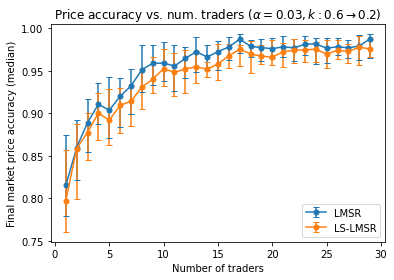

In [9]:
## Plot results


# Accuracy vs Number of traders
acc_quartiles_LMSR = [[acc_quartiles_LMSR[i][0] for i in range(len(n_traders_arr))], [acc_quartiles_LMSR[i][1] for i in range(len(n_traders_arr))]] 
acc_quartiles_LS = [[acc_quartiles_LS[i][0] for i in range(len(n_traders_arr))], [acc_quartiles_LS[i][1] for i in range(len(n_traders_arr))]] 
plt.errorbar(n_traders_arr, acc_LMSR_med, yerr=acc_quartiles_LMSR, marker='o', markersize=5, capsize=3, label='LMSR')
plt.errorbar(n_traders_arr, acc_LS_med, yerr=acc_quartiles_LS, marker='o', markersize=5, capsize=3, label='LS-LMSR')
plt.ylabel('Final market price accuracy (median)')
plt.title(r'Price accuracy vs. num. traders ($\alpha=0.03,k: 0.6 \rightarrow 0.2$)')
plt.xlabel(r'Number of traders')
plt.legend()
# plt.savefig('figs/simple_noise_nt_acc.png')
plt.show()

#### 4. Run noisy sim to to test relationship between final AMM revenue and price accuracy (for fixed $\alpha$, number of traders) across repeated trials

(This is how we generate Figure 2 in the paper, as well as Appendix A figures)

In [23]:
init_quant = [100, 100]
N_TRIALS = 100
N_TRADERS = 20
LOOKBACK = int(N_TRADERS/4)
wcls = []
K_MIN = 0.2
K_MAX = 0.6

# Set hyperparameters
alpha = 0.03
p = 0.1

acc_LS_temp = []
acc_LMSR_temp = []
rev_LS_temp = []
rev_LMSR_temp = []
exprev_LMSR_temp = []
exprev_LS_temp = []
o1, o2 = [], []

for i in range(N_TRIALS):
    s = Simulation()
    b, worst_case_loss = s.compute_b(alpha, init_quant)
    ground_truth = s.draw_unif_ground_truth(p, p+0.1)
    markets = s.create_market_comp(
        [100, 100], 'LMSR', 'LSLMSR', b, alpha, ground_truth)
    b1, b2 = markets[0], markets[1]
    b1_prob, b2_prob, b1_exprev, b2_exprev, b1_rev, b2_rev, out1, out2 = s.simple_noise_sim(
        N_TRADERS, 10000000, markets, look_back=LOOKBACK, k_min=K_MIN, k_max=K_MAX, silence=True, verbose=False)

    acc_LS_temp.append(1-abs(b2_prob[0]-ground_truth[0]))
    acc_LMSR_temp.append(1-abs(b1_prob[0]-ground_truth[0]))
    rev_LS_temp.append(b2_rev)
    rev_LMSR_temp.append(b1_rev)
    exprev_LS_temp.append(b2_exprev)
    exprev_LMSR_temp.append(b1_exprev)
    o1.append(out1)
    o2.append(out2)

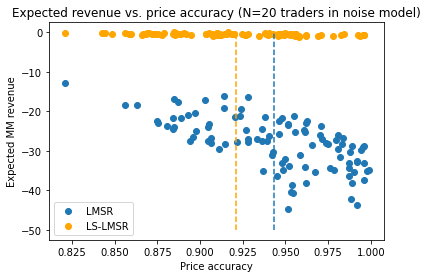

In [24]:
# Plot Expected Revenue vs Accuracy for LMSR, LS-LMSR
plt.scatter(acc_LMSR_temp, exprev_LMSR_temp)
plt.scatter(acc_LS_temp, exprev_LS_temp, c='orange' if p ==
            0.1 else 'yellow', label="test2")
plt.vlines(x = np.mean(acc_LS_temp), ymin = -50, ymax = 0, colors='orange', linestyles='dashed')
plt.vlines(x = np.mean(acc_LMSR_temp), ymin = -50, ymax = 0, linestyles='dashed')
plt.ylabel('Expected MM revenue')
plt.title(r'Expected revenue vs. price accuracy (N=20 traders in noise model)')
plt.xlabel(r'Price accuracy')
plt.legend(["LMSR", "LS-LMSR"], loc="lower left")
plt.show()

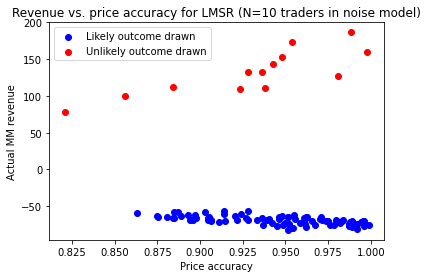

In [25]:
# Plot Actual Revenue vs Accuracy for LMSR
o1 = np.array(o1)
idx1, idx2 = np.where(o1!=0)[0], np.where(o1==0)[0]
plt.scatter(np.array(acc_LMSR_temp)[idx1], np.array(rev_LMSR_temp)[idx1], c="blue")
plt.scatter(np.array(acc_LMSR_temp)[idx2], np.array(rev_LMSR_temp)[idx2], c="red")
plt.ylabel('Actual MM revenue')
plt.title(r'Revenue vs. price accuracy for LMSR (N=10 traders in noise model)')
plt.xlabel(r'Price accuracy')
plt.legend(["Likely outcome drawn", "Unlikely outcome drawn"])
plt.show()

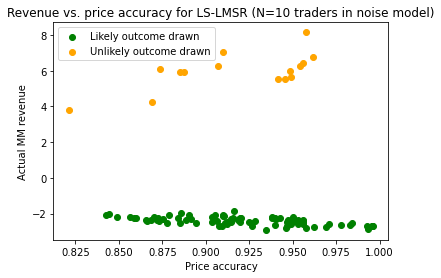

In [26]:
# Plot Actual Revenue vs Accuracy for LS-LMSR
o2 = np.array(o2)
idx1, idx2 = np.where(o2!=0)[0], np.where(o2==0)[0]
plt.scatter(np.array(acc_LS_temp)[idx1], np.array(rev_LS_temp)[idx1], c="green")
plt.scatter(np.array(acc_LS_temp)[idx2], np.array(rev_LS_temp)[idx2], c="orange")
plt.ylabel('Actual MM revenue')
plt.title(r'Revenue vs. price accuracy for LS-LMSR (N=10 traders in noise model)')
plt.xlabel(r'Price accuracy')
plt.legend(["Likely outcome drawn", "Unlikely outcome drawn"])
plt.show()

### Rikkido: investigations

Here we do a brief numerical analysis of Rikkido with set betting sequence. The idea is to test Rikkido in different stages of volatility, so we go through four betting periods.

Period 1: bets of size 1 <br>
Period 2: exponentially increasing bet sizes <br>
Period 3: exponentially decreasing bet sizes <br>
Period 4: back to constant bet sizes of 1

In [14]:
betseq = []
pd_size = 15
for i in range(pd_size):
    betseq.append(1)
for i in range(pd_size):
    betseq.append((1.15)**i)
for i in range(pd_size):
    betseq.append((1/1.1)**i)
for i in range(pd_size):
    betseq.append(1)

In [15]:
NUM_TRADERS = pd_size*4
gt = s.draw_unif_ground_truth(0.6, 0.8)
init_quant = [100, 100]
alpha = 0.03
b, worst_case_loss = s.compute_b(alpha, init_quant)
b_lmsr = BettingMarket(2, init_quant, "LMSR", None, b, gt)
b_ls = BettingMarket(2, init_quant, "LSLMSR", alpha, None,  gt)
b_r = BettingMarket(2, init_quant, "Rikkido", alpha, None,  gt, t=2, tk=4, slope_const=2)
mkts = [b_lmsr, b_ls, b_r]


traders = [] # (ntraders x len(markets))
bets = [] # (ntraders x len(markets))
costs = [] # (ntraders x len(markets))

market_b = [[] for i in range(len(mkts))]
priv_info_noise = 0.05

for i in range(NUM_TRADERS):
    traders.append([])
    bets.append([])
    costs.append([])

    priv_info = min(random.random()*(2*priv_info_noise)+max(mkts[0].true_dist[0]-priv_info_noise, 0.001), 0.999)
    trad_p0 = priv_info
    
    for im in range(len(mkts)):
        trader = Trader(i, 2, 10000000000)
        trader.set_belief([trad_p0, 1-trad_p0])
        item = int(random.random()*2-(1e-7))
        trader.bet(mkts[im], item, betseq[i])
        market_b[im].append(mkts[im].get_b())


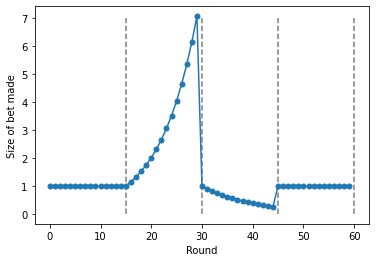

In [16]:
# Visualize the bet sequence

plt.plot(betseq, marker='o',markersize=5)
plt.vlines(x = [pd_size*i for i in range(1, 5)], ymin = 0, ymax = 7, colors='gray', linestyles='dashed')
plt.ylabel("Size of bet made")
plt.xlabel("Round")
# plt.savefig("figs/rikkido_bet_sequence.png")
plt.show()

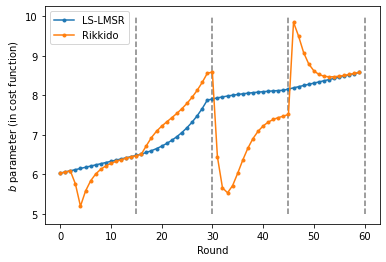

In [17]:
# Visualize how the 'b' parameter changes in each scoring rule (based on the total quantity for both, and volatility for Rikkido)

plt.plot(market_b[1], marker='o',markersize=3, label='LS-LMSR')
plt.plot(market_b[2], marker='o',markersize=3, label='Rikkido')
plt.vlines(x = [pd_size*i for i in range(1, 5)], ymin = 5, ymax = 10, colors='gray', linestyles='dashed')
plt.xlabel("Round")
plt.ylabel(r"$b$ parameter (in cost function)")
plt.legend()
# plt.savefig('figs/rikkido_vs_lmsr.png')
plt.show()


#### (Old investigations)
### Perfect information simulation
Runs the perfect information simulation across a range of $\alpha$ values

In [18]:
vigs = np.arange(0.02, 0.2, 0.01)
alphas = vigs/(2*np.log(2))

init_quant = [100, 100]
N_TRIALS = 100
N_TRADERS = 10

acc_LS = []
acc_LMSR = []
rev_LS = []
rev_LMSR = []
rev_stdevs_LMSR = []
rev_stdevs_LS = []
exprev_LMSR = []
exprev_LS = []
exprev_stdevs_LMSR = []
exprev_stdevs_LS = []

wcls= []

for alpha in alphas:
    s = Simulation()
    acc_LS_temp = []
    acc_LMSR_temp = []
    rev_LS_temp = []
    rev_LMSR_temp = []
    exprev_LMSR_temp = []
    exprev_LS_temp = []

    b, worst_case_loss = s.compute_b(alpha, init_quant)
    wcls.append(-worst_case_loss)

    for i in range(N_TRIALS):
        ground_truth = s.draw_unif_ground_truth(0.7, 0.9)
        markets = s.create_market_comp([100, 100], 'LMSR', 'LSLMSR', b, alpha, ground_truth)
        b1, b2 = markets[0], markets[1]
        b1_price, b2_price, b1_rev, b2_rev = s.perfect_trader_sim(N_TRADERS, 100000000, markets, silence=True)

        # normalize prices (specifically for b2)
        b1_price = np.array(b1_price)/np.sum(b1_price)
        b2_price = np.array(b2_price)/np.sum(b2_price)

        acc_LS_temp.append(1-abs(b2_price[0]-ground_truth[0]))
        acc_LMSR_temp.append(1-abs(b1_price[0]-ground_truth[0]))
        rev_LS_temp.append(b2_rev)
        rev_LMSR_temp.append(b1_rev)
        exprev_LS_temp.append(b2.get_expected_revenue())
        exprev_LMSR_temp.append(b1.get_expected_revenue())
    
    acc_LS.append(np.mean(acc_LS_temp))
    acc_LMSR.append(np.mean(acc_LMSR_temp))
    rev_LS.append(np.mean(rev_LS_temp))
    rev_stdevs_LS.append(np.std(rev_LS_temp))
    rev_LMSR.append(np.mean(rev_LMSR_temp))
    rev_stdevs_LMSR.append(np.std(rev_LMSR_temp))

    exprev_LMSR.append(np.mean(exprev_LMSR_temp))
    exprev_stdevs_LMSR.append(np.std(exprev_LMSR_temp))
    exprev_LS.append(np.mean(exprev_LS_temp))
    exprev_stdevs_LS.append(np.std(exprev_LS_temp))

### Smart Contract Implementation

```
pragma solidity >=0.7.0 <0.9.0;
import "./SD59x18.sol";

import "./token.sol";
import "./oracle.sol";

contract PredictionMarket {

    // keep track of the number outcomes
    uint256 outcomeCount;

    // hold the quantites for each outcome
    SD59x18[] quantities;

    // hold alpha (used for LS-LMSR)
    SD59x18 alpha;

    // hold b (used for LMSR)
    SD59x18 b;

    // LS-LMSR or LMSR distinction
    string msr;

    // the winning index
    uint256 winning_index;

    // basic trader, keep track of payouts
    struct Trader {
        SD59x18[] payouts;
    }

    // map addresses to traders
    mapping(address => Trader) internal traders;


    // deploys a prediction market with a given outcome count, alpha, b
    // utilizes LMSR or LS-LMSR based on msr distinction
    constructor(
        uint256 _outcomeCount,
        int256 _alpha,
        int256 _b,
        string memory _msr
    ) {
        outcomeCount = _outcomeCount;
        alpha = intoSD59x18(_alpha);
        b = intoSD59x18(_b);
        //  oracle = _oracle;
        msr = _msr;
        winning_index = 0;
        quantities = new SD59x18[](_outcomeCount);
        for (uint256 i = 0; i < outcomeCount; i++) {
            quantities[i] = sd(100e18); // initialize to 100
        }
    }

    // view the b used in the deployment
    function get_b() public view returns (int256) {
        return intoInt256(b);
    }

    // view the alpha used in deployment
    function get_alpha() public view returns (int256) {
        return intoInt256(alpha);
    }

    // fund the contract
    function fund() public payable {}


    // view the prices of each outcome
    function get_price_vector() public view returns (int256[] memory) {
        int256[] memory prices = new int[](outcomeCount);
        for (uint256 i = 0; i < outcomeCount; i++) {
            prices[i] = get_price(i);
        }

        return prices;
    }


    // view a trader's shares
    function get_shares() public view returns (int256[] memory) {
        require(
            traders[msg.sender].payouts.length == outcomeCount,
            "You have no shares!"
        );

        int256[] memory converted_payouts = new int256[](outcomeCount);
        for (uint i = 0; i < outcomeCount; i++) {
            converted_payouts[i] = convert(traders[msg.sender].payouts[i]);
        }

        return converted_payouts;
    }

    // internal summation function
    function sum(SD59x18[] memory array) private pure returns (SD59x18) {
        SD59x18 s = sd(0);
        for (uint i = 0; i < array.length; i++) {
            s = s + array[i];
        }
        return s;
    }

    // obtain the price of a given outcome (i)
    function get_price(uint256 i) public view returns (int256) {
        if (
            keccak256(abi.encodePacked(msr)) ==
            keccak256(abi.encodePacked("LMSR"))
        ) {
            return intoInt256(((quantities[i] / b).exp()) / sum(quantities));
        } else {
            // "LS-LMSR"
            SD59x18 b = alpha * sum(quantities);
            SD59x18[] memory q_temp = new SD59x18[](quantities.length);
            for (uint j = 0; j < outcomeCount; j++) {
                q_temp[j] = (quantities[j] / b).exp();
            }
            SD59x18 sum_term = sum(q_temp);
            SD59x18 term1 = alpha * sum_term.ln();
            for (uint j = 0; j < outcomeCount; j++) {
                q_temp[j] = quantities[j] * (quantities[j] / b).exp();
            }
            SD59x18 term2_num = sum(quantities) *
                (quantities[i] / b).exp() -
                sum(q_temp);
            SD59x18 term2_denom = sum(quantities) * sum_term;

            return intoInt256(term1 + (term2_num / term2_denom));
        }
    }

    //calculate the cost w LMSR
    function cost_LMSR(
        SD59x18 b,
        SD59x18[] memory q
    ) internal view returns (SD59x18) {
        SD59x18 totalExp = sd(0);
        for (uint256 i = 0; i < outcomeCount; i++) {
            totalExp = totalExp + (q[i] / b).exp();
        }
        return b * totalExp.ln();
    }


    // get the current quantity for each outcome
    function get_quantity_vector() public view returns (SD59x18[] memory) {
        return quantities;
    }


    // LMSR and LS-LMSR cost functions
    function cost(SD59x18[] memory q) internal view returns (SD59x18) {
        if (
            keccak256(abi.encodePacked(msr)) ==
            keccak256(abi.encodePacked("LMSR"))
        ) {
            return cost_LMSR(b, q);
        } else {
            // "LS-LMSR"
            SD59x18 temp_b = alpha * sum(q);
            return cost_LMSR(temp_b, q);
        }
    }

    // submit a bet of a given outcome i, for a number of (shares)
    function submitBet(uint i, int256 shares) public payable {
        SD59x18 converted_shares = convert(shares);
        int256 costDiff = bet_cost(i, shares);

        // Transfer funds from user's wallet to contract's wallet
        require(
            msg.value >= uint(costDiff),
            "Please pay the proper amount to submit bet; Check using cost of bet!"
        );

        quantities[i] = quantities[i] + converted_shares;

        if (traders[msg.sender].payouts.length < outcomeCount) {
            traders[msg.sender].payouts = new SD59x18[](outcomeCount);
        }
        traders[msg.sender].payouts[i] =
            traders[msg.sender].payouts[i] +
            converted_shares;

        // Transfer outcome tokens from contract's wallet to user's wallet
        //  require(outcomeTokens[i].transfer(msg.sender, shares), "Transfer failed");
    }

    // query the cost of a certain bet (scales the bet down by 1e4 to make interactions more affordable)
    function bet_cost(uint256 i, int256 shares) public view returns (int256) {
        SD59x18 bet = cost_of_bet(i, shares);
        int256 converted_bet = intoInt256(bet);

        return (converted_bet) / 10000;
    }

    // internal helper for cost of a bet
    function cost_of_bet(
        uint256 i,
        int256 shares
    ) internal view returns (SD59x18) {
        SD59x18[] memory delta = new SD59x18[](outcomeCount);
        delta[i] = convert(shares);

        SD59x18[] memory oldQ = quantities;
        SD59x18[] memory newQ = new SD59x18[](outcomeCount);
        for (uint j = 0; j < outcomeCount; j++) {
            newQ[j] = oldQ[j] + delta[j];
        }

        SD59x18 oldCost = cost(oldQ);
        SD59x18 newCost = cost(newQ);
        SD59x18 costDiff = newCost - oldCost;
        return costDiff;
    }
    
    // redeem the sender's winnings if they have shares of a winning outcome
    function redeem_winnings() public payable {
        SD59x18[] memory payouts = traders[msg.sender].payouts;
        SD59x18 totalPayout = payouts[winning_index];
        quantities[winning_index] -= totalPayout;
        int256 payout = intoInt256(totalPayout);
        require(intoInt256(totalPayout) > 0, "No winnings to redeem");
        traders[msg.sender].payouts = new SD59x18[](outcomeCount);

        payable(msg.sender).transfer(uint(payout));
    }
}
```


Please check out our github: https://github.com/amaheshwari25/ECE473/ to view our truffle config for testing. Feel free to clone, navigate into "solidity/truffle" and activate the truffle environment. This will launch a local test blockchain on localhost, and facilitate interaction with the contract.